In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 2
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [-2, -2, 0]
ng_refs = [2, 3, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
vmax = 540
vmin = 340
w_diffuse = [(1.66, 1.66), (1.8, 1.8, 1.8), (1.8, 1.66, 1.45, 1.45, 1.45, 1.45)]
wgt = [(0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6, 0.6, 0.6, 0.6)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

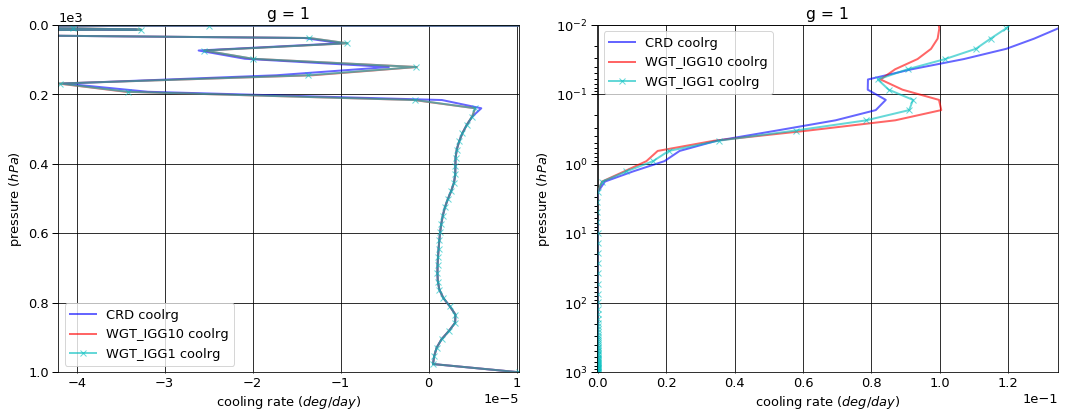

# Figure: cooling rate g-group 2

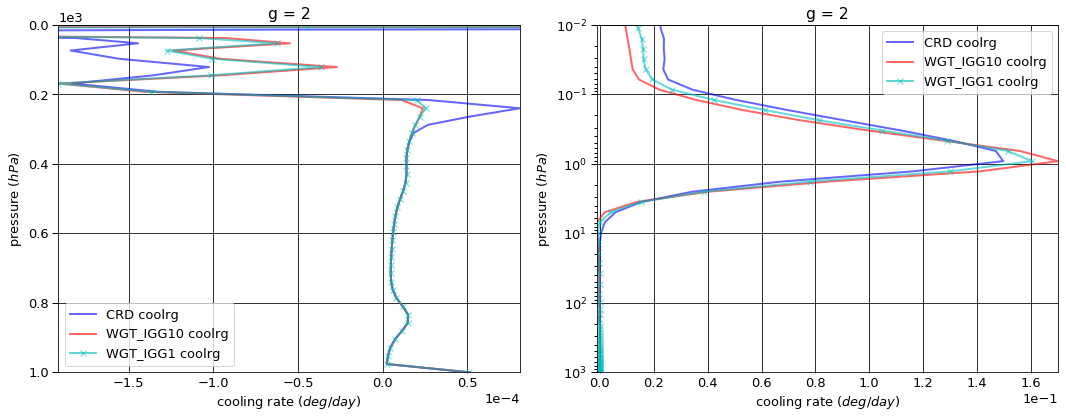

# Figure: cooling rate g-group 3

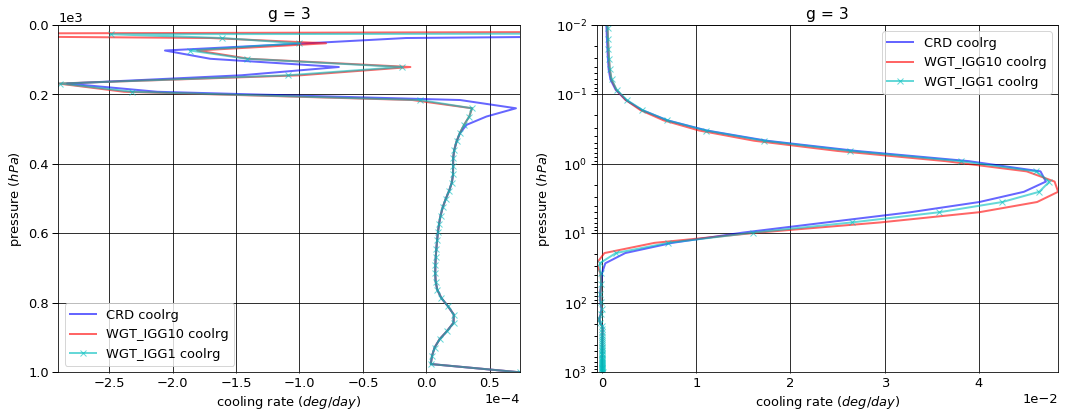

# Figure: cooling rate g-group 4

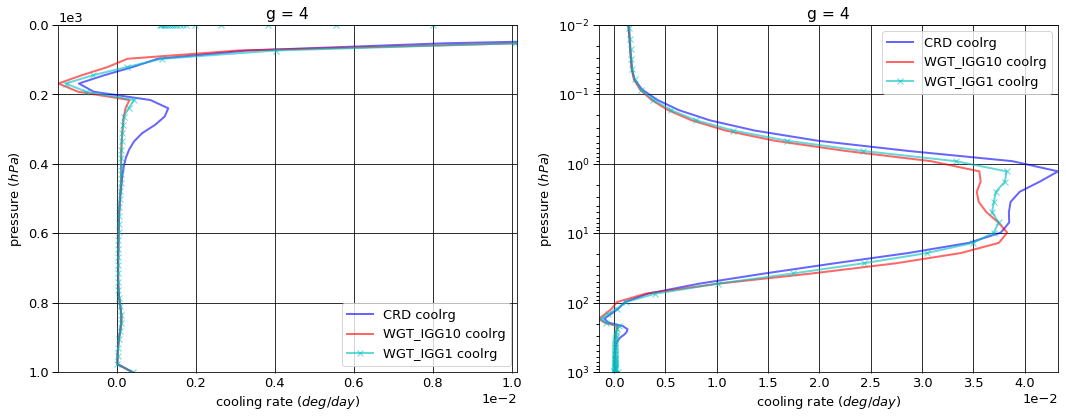

# Figure: cooling rate g-group 5

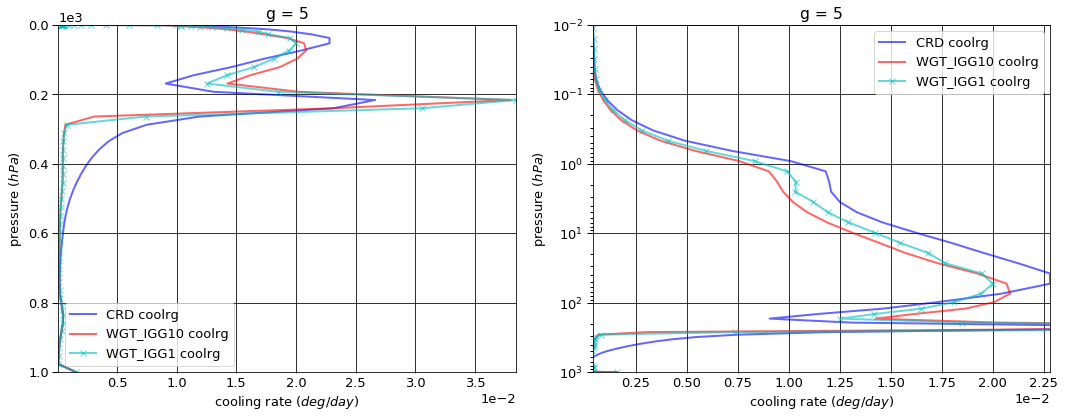

# Figure: cooling rate g-group 6

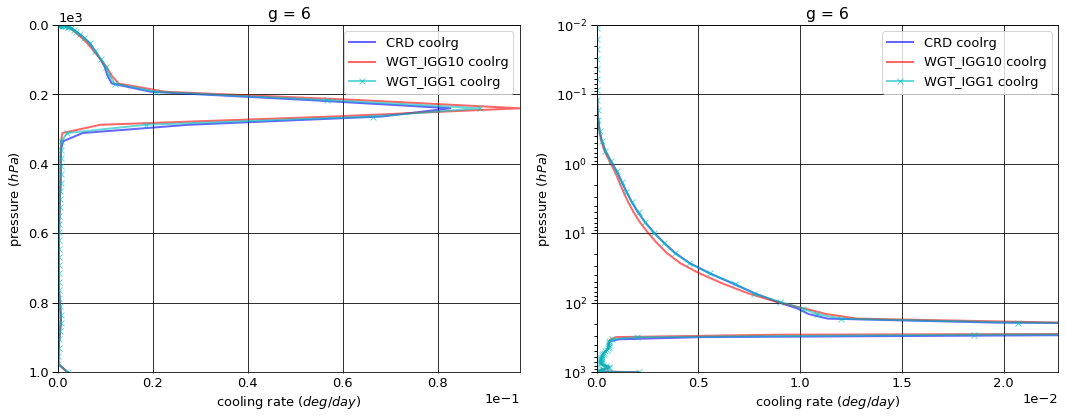

# Figure: cooling rate g-group 7

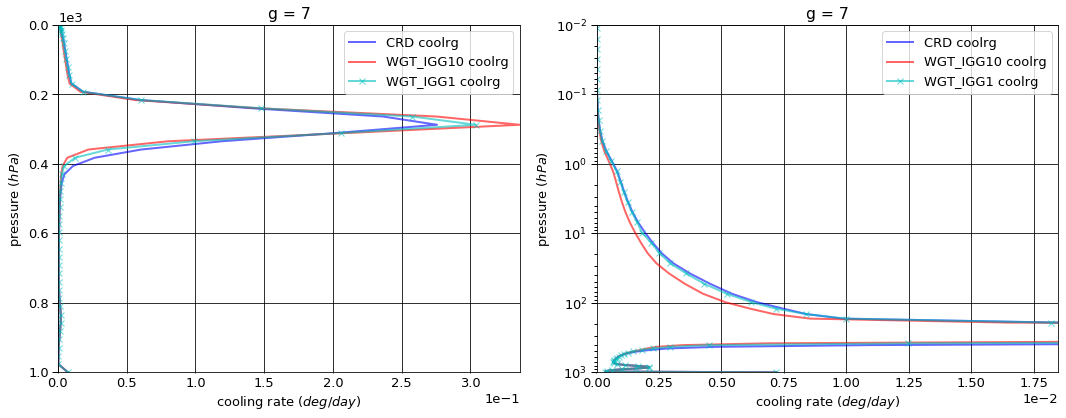

# Figure: cooling rate g-group 8

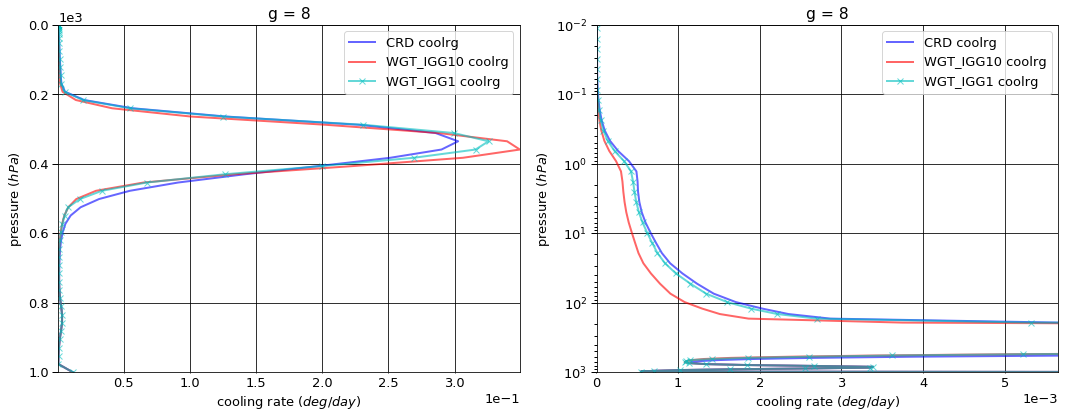

# Figure: cooling rate g-group 9

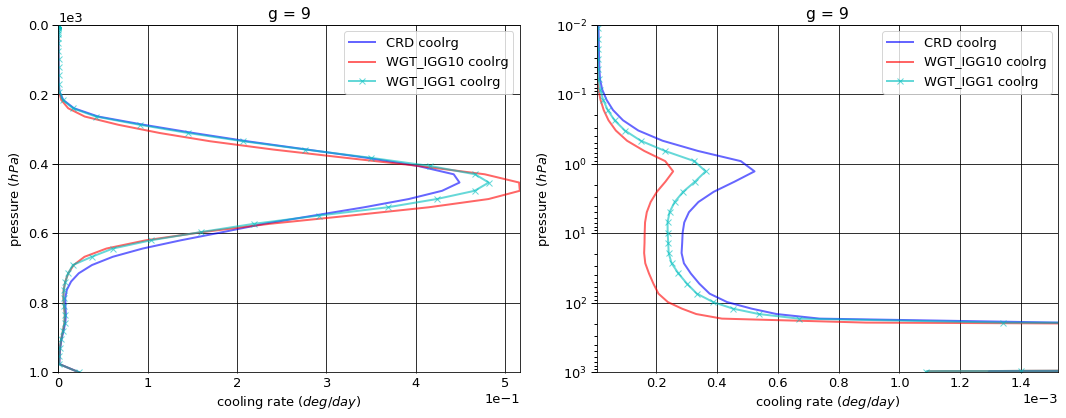

# Figure: cooling rate g-group 10

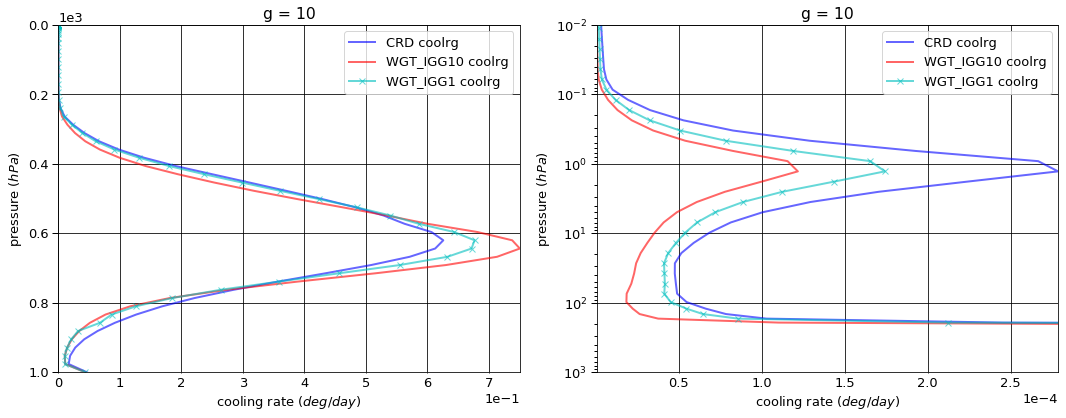

# Figure: cooling rate g-group 11

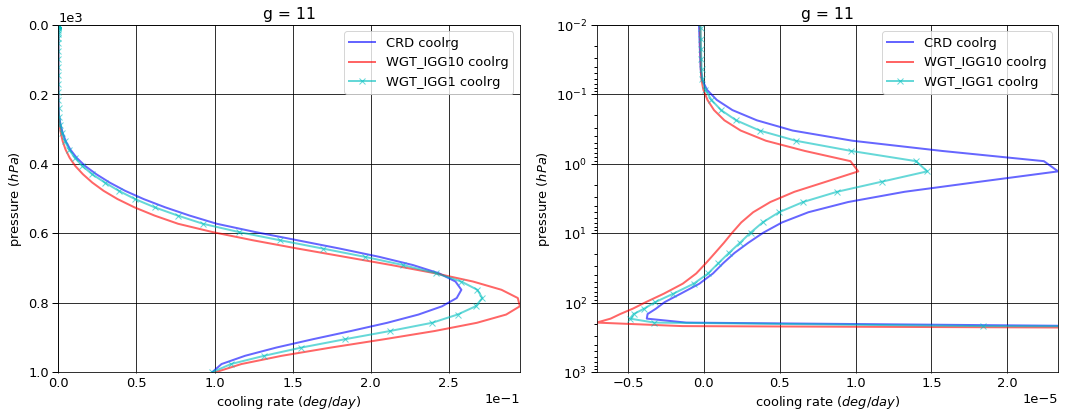

# Figure: cooling rate g-group total

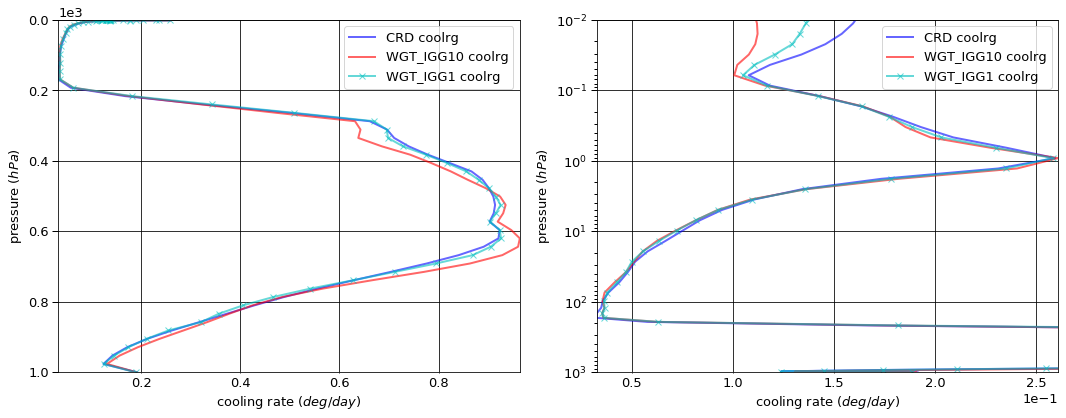

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005647   0.000000  -0.005647
   1013.0   76     -0.009312   0.009284  -0.000028
2  0.0      1      -0.030917   0.000000  -0.030917
   1013.0   76     -0.042357   0.042216  -0.000141
3  0.0      1      -0.042475   0.000000  -0.042475
   1013.0   76     -0.064365   0.064162  -0.000203
4  0.0      1      -0.186032   0.000000  -0.186032
   1013.0   76     -0.349362   0.348241  -0.001121
5  0.0      1      -0.681977   0.000000  -0.681977
   1013.0   76     -1.364499   1.360105  -0.004394
6  0.0      1      -0.934599   0.000000  -0.934599
   1013.0   76     -1.801958   1.796266  -0.005692
7  0.0      1      -3.500974   0.000000  -3.500974
   1013.0   76     -6.186713   6.166857  -0.019855
8  0.0      1      -6.152846   0.000000  -6.152846
   1013.0   76     -9.838320   9.806399  -0.031921
9  0.0      1     -13.482647   0.000000 -13.482647
   1013.0   76    -19.192648  19.128304  -0.064345
10 0.0      1     -23.647756   0.000000 -23.647756
   1013.0   76    -30.006619  29.860882  -0.145736
11 0.0      1     -11.698914   0.000000 -11.698914
   1013.0   76    -13.459642  12.622886  -0.836757


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005504   0.000000  -0.005504
   1013.0   76     -0.009312   0.009284  -0.000028
2  0.0      1      -0.032112   0.000000  -0.032112
   1013.0   76     -0.042357   0.042216  -0.000141
3  0.0      1      -0.043355   0.000000  -0.043355
   1013.0   76     -0.064365   0.064162  -0.000203
4  0.0      1      -0.183960   0.000000  -0.183960
   1013.0   76     -0.349362   0.348241  -0.001121
5  0.0      1      -0.651495   0.000000  -0.651495
   1013.0   76     -1.364499   1.360112  -0.004387
6  0.0      1      -0.922781   0.000000  -0.922781
   1013.0   76     -1.801958   1.796266  -0.005692
7  0.0      1      -3.472757   0.000000  -3.472757
   1013.0   76     -6.186713   6.166857  -0.019855
8  0.0      1      -6.159597   0.000000  -6.159597
   1013.0   76     -9.838320   9.806399  -0.031921
9  0.0      1     -13.537878   0.000000 -13.537878
   1013.0   76    -19.192648  19.128697  -0.063952
10 0.0      1     -23.824003   0.000000 -23.824003
   1013.0   76    -30.006619  29.878261  -0.128357
11 0.0      1     -11.846654   0.000000 -11.846654
   1013.0   76    -13.459642  12.912580  -0.547063


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005542   0.000000  -0.005542
   1013.0   76     -0.009312   0.009284  -0.000028
2  0.0      1      -0.031701   0.000000  -0.031701
   1013.0   76     -0.042357   0.042216  -0.000141
3  0.0      1      -0.042931   0.000000  -0.042931
   1013.0   76     -0.064365   0.064162  -0.000203
4  0.0      1      -0.183243   0.000000  -0.183243
   1013.0   76     -0.349362   0.348241  -0.001121
5  0.0      1      -0.657555   0.000000  -0.657555
   1013.0   76     -1.364499   1.360112  -0.004387
6  0.0      1      -0.928930   0.000000  -0.928930
   1013.0   76     -1.801958   1.796266  -0.005692
7  0.0      1      -3.476429   0.000000  -3.476429
   1013.0   76     -6.186713   6.166857  -0.019855
8  0.0      1      -6.112403   0.000000  -6.112403
   1013.0   76     -9.838320   9.806399  -0.031921
9  0.0      1     -13.415365   0.000000 -13.415365
   1013.0   76    -19.192648  19.128699  -0.063950
10 0.0      1     -23.595241   0.000000 -23.595241
   1013.0   76    -30.006619  29.876604  -0.130015
11 0.0      1     -11.730041   0.000000 -11.730041
   1013.0   76    -13.459642  12.851734  -0.607908


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1      1.426994e-04  0.000000  1.426994e-04
   1013.0   76     0.000000e+00  0.000000 -3.388132e-21
2  0.0      1     -1.194874e-03  0.000000 -1.194874e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
3  0.0      1     -8.802550e-04  0.000000 -8.802550e-04
   1013.0   76     0.000000e+00  0.000000  2.710505e-20
4  0.0      1      2.072420e-03  0.000000  2.072420e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1      3.048254e-02  0.000000  3.048254e-02
   1013.0   76     0.000000e+00  0.000007  6.938000e-06
6  0.0      1      1.181785e-02  0.000000  1.181785e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
7  0.0      1      2.821740e-02  0.000000  2.821740e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1     -6.751200e-03  0.000000 -6.751200e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
9  0.0      1     -5.523100e-02  0.000000 -5.523100e-02
   1013.0   76     3.552714e-15  0.000393  3.928910e-04
10 0.0      1     -1.762470e-01  0.000000 -1.762470e-01
   1013.0   76     0.000000e+00  0.017379  1.737863e-02
11 0.0      1     -1.477400e-01  0.000000 -1.477400e-01
   1013.0   76     0.000000e+00  0.289694  2.896941e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1      1.045538e-04  0.000000  1.045538e-04
   1013.0   76     0.000000e+00  0.000000 -3.388132e-21
2  0.0      1     -7.842190e-04  0.000000 -7.842190e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
3  0.0      1     -4.565530e-04  0.000000 -4.565530e-04
   1013.0   76     0.000000e+00  0.000000  2.710505e-20
4  0.0      1      2.789780e-03  0.000000  2.789780e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1      2.442219e-02  0.000000  2.442219e-02
   1013.0   76     0.000000e+00  0.000007  6.938000e-06
6  0.0      1      5.668880e-03  0.000000  5.668880e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
7  0.0      1      2.454480e-02  0.000000  2.454480e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1      4.044250e-02  0.000000  4.044250e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
9  0.0      1      6.728200e-02  0.000000  6.728200e-02
   1013.0   76     3.552714e-15  0.000395  3.949720e-04
10 0.0      1      5.251500e-02  0.000000  5.251500e-02
   1013.0   76     0.000000e+00  0.015722  1.572116e-02
11 0.0      1     -3.112700e-02  0.000000 -3.112700e-02
   1013.0   76     0.000000e+00  0.228848  2.288487e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.358714e-01
   1001.112500 75     1.031384e-05
2  0.000312    1      1.610134e-02
   1001.112500 75     5.114664e-05
3  0.000312    1      2.312854e-04
   1001.112500 75     7.366725e-05
4  0.000312    1      9.744439e-04
   1001.112500 75     4.067707e-04
5  0.000312    1      2.939470e-04
   1001.112500 75     1.593032e-03
6  0.000312    1      1.709246e-06
   1001.112500 75     2.065122e-03
7  0.000312    1      5.433665e-06
   1001.112500 75     7.202732e-03
8  0.000312    1      6.450263e-06
   1001.112500 75     1.157864e-02
9  0.000312    1      6.829588e-06
   1001.112500 75     2.331667e-02
10 0.000312    1      8.589191e-07
   1001.112500 75     4.664713e-02
11 0.000312    1     -4.783807e-07
   1001.112500 75     9.846506e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      8.389633e-02
   1001.112500 75     1.031384e-05
2  0.000312    1      4.119322e-03
   1001.112500 75     5.114664e-05
3  0.000312    1      3.609213e-04
   1001.112500 75     7.366725e-05
4  0.000312    1      1.086859e-03
   1001.112500 75     4.067707e-04
5  0.000312    1      3.059274e-04
   1001.112500 75     1.591439e-03
6  0.000312    1      1.558221e-06
   1001.112500 75     2.065122e-03
7  0.000312    1      4.318666e-06
   1001.112500 75     7.202732e-03
8  0.000312    1      3.242309e-06
   1001.112500 75     1.157864e-02
9  0.000312    1      2.737498e-06
   1001.112500 75     2.319360e-02
10 0.000312    1     -4.154820e-07
   1001.112500 75     4.403081e-02
11 0.000312    1     -2.986427e-07
   1001.112500 75     1.004772e-01


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      1.095129e-01
   1001.112500 75     1.031384e-05
2  0.000312    1      8.714908e-03
   1001.112500 75     5.114664e-05
3  0.000312    1      3.488286e-04
   1001.112500 75     7.366725e-05
4  0.000312    1      1.092063e-03
   1001.112500 75     4.067707e-04
5  0.000312    1      3.306691e-04
   1001.112500 75     1.591439e-03
6  0.000312    1      1.753415e-06
   1001.112500 75     2.065122e-03
7  0.000312    1      5.476870e-06
   1001.112500 75     7.202732e-03
8  0.000312    1      4.991464e-06
   1001.112500 75     1.157864e-02
9  0.000312    1      4.946134e-06
   1001.112500 75     2.319202e-02
10 0.000312    1      3.733094e-07
   1001.112500 75     4.405398e-02
11 0.000312    1     -3.140612e-07
   1001.112500 75     9.846523e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.197503e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.198201e-02
   1001.112500 75     6.776264e-21
3  0.000312    1      1.296359e-04
   1001.112500 75     0.000000e+00
4  0.000312    1      1.124148e-04
   1001.112500 75     0.000000e+00
5  0.000312    1      1.198047e-05
   1001.112500 75    -1.592700e-06
6  0.000312    1     -1.510250e-07
   1001.112500 75     0.000000e+00
7  0.000312    1     -1.114999e-06
   1001.112500 75     0.000000e+00
8  0.000312    1     -3.207954e-06
   1001.112500 75     0.000000e+00
9  0.000312    1     -4.092090e-06
   1001.112500 75    -1.230720e-04
10 0.000312    1     -1.274401e-06
   1001.112500 75    -2.616327e-03
11 0.000312    1      1.797380e-07
   1001.112500 75     2.012110e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.635846e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -7.386429e-03
   1001.112500 75     6.776264e-21
3  0.000312    1      1.175431e-04
   1001.112500 75     0.000000e+00
4  0.000312    1      1.176191e-04
   1001.112500 75     0.000000e+00
5  0.000312    1      3.672216e-05
   1001.112500 75    -1.592700e-06
6  0.000312    1      4.416900e-08
   1001.112500 75     0.000000e+00
7  0.000312    1      4.320530e-08
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.458798e-06
   1001.112500 75     0.000000e+00
9  0.000312    1     -1.883454e-06
   1001.112500 75    -1.246490e-04
10 0.000312    1     -4.856096e-07
   1001.112500 75    -2.593158e-03
11 0.000312    1      1.643195e-07
   1001.112500 75     1.740000e-07

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.364783,0.000000,-60.364783
1013.0,76,-82.315794,81.205602,-1.110193



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.680095,0.000000,-60.680095
1013.0,76,-82.315794,81.513075,-0.802721



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.179381,0.000000,-60.179381
1013.0,76,-82.315794,81.450574,-0.865221



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.315311,0.000000,-0.315311
1013.0,76,0.000000,0.307473,0.307473



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.185402,0.000000,0.185402
1013.0,76,0.000000,0.244972,0.244972


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.153493
1001.112500,75,0.191410



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.089781
1001.112500,75,0.190681



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.120017
1001.112500,75,0.188691



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.063713
1001.112500,75,-0.000729



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.033477
1001.112500,75,-0.002719


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000119
2,0.000525,0.000521
3,0.000840,0.000810
4,0.004490,0.004364
5,0.017520,0.017032
6,0.023475,0.022653
7,0.079385,0.077276
8,0.125500,0.122349
9,0.238215,0.235985


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.013979e-17
2,7.376594e-19
3,4.606445e-19
4,3.437534e-20
5,2.565240e-21
6,2.180272e-20
7,3.897251e-21
8,6.966363e-22
9,1.245242e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.013979e-17,NaN,0.000125,0.000119,0.000125,0.000119,1.0
2,7.376594e-19,0.072749,0.000525,0.000521,0.000650,0.000640,1.0
3,4.606445e-19,0.624468,0.000840,0.000810,0.001490,0.001449,10.0
4,3.437534e-20,0.074624,0.004490,0.004364,0.005980,0.005813,10.0
5,2.565240e-21,0.074624,0.017520,0.017032,0.023500,0.022845,10.0
6,2.180272e-20,8.499291,0.023475,0.022653,0.046975,0.045498,500.0
7,3.897251e-21,0.178751,0.079385,0.077276,0.126360,0.122774,500.0
8,6.966363e-22,0.178751,0.125500,0.122349,0.251860,0.245123,500.0
9,1.245242e-22,0.178751,0.238215,0.235985,0.490075,0.481108,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
